<a href="https://colab.research.google.com/github/choheeee22/dilab_group_meeting/blob/main/Ali_stepbystep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install torch==1.0.0 torchvision==0.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
#import libraries

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torchvision
import argparse
from torchvision import datasets, transforms # image transformation library
import torch.optim as optim 
from torch.autograd import Variable 
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt


model 

In [31]:
class Generator(nn.Module) : 
  def __init__(self, latent_size) : 
    super(Generator, self).__init__()
    self.latent_size = latent_size

    self.output_bias = nn.Parameter(torch.zeros(3, 32 ,32), requires_grad = True)
    self.main = nn.Sequential(
        nn.ConvTranspose2d(self.latent_size, 256, 4, stride= 1, bias = False), # in_channels, out_channels, kernel_size, stride, padding, bias- if true, adds a learnable bias to the output
        nn.BatchNorm2d(256), #num of features 
        nn.LeakyReLU(inplace = True),

        nn.ConvTranspose2d(256, 128 , 4 , stride = 2 , bias = False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace = True),

        nn.ConvTranspose2d(128, 64, 4, stride = 1, bias = False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace= True),

        nn.ConvTranspose2d(64, 32, 4, stride =2, bias = False),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace= True),

        nn.ConvTranspose2d(32, 32, 5, stride = 1, bias = False ),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace = True),

        nn.ConvTranspose2d(32, 32, 1, stride=1, bias=False),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace = True),

        nn.ConvTranspose2d(32, 3, 1, stride = 1, bias =False)

    )

    def forward(self, input):
      output = self.main(input)
      output = F.sigmoid(output + self.output_bias)
      return output

In [32]:
class Encoder(nn.Module):

  def __init__(self, latent_size, noise=False) :
    super(Encoder, self).__init__()
    self.latent_size = latent_size

    if noise : 
      self.latent_size *=2 # latent size times 2 
    self.main1 = nn.Sequential(
        nn.Conv2d(3, 32, 5, stride=1, bias=False), # in_channels, out_channels, kernel_size, stride # input channel size 항상 3 인건가?
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace = True),

        nn.Conv2d(32, 64, 4, stride=2, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),

        nn.Conv2d(64, 128, 4, stride=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace=True),

        nn.Conv2d(128, 256, 4, stride=2, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(inplace=True)

    )

    """

    main 1,2,3,4,가 나눠저 있는 이유는 뭐지? encoding 중간에 뽑기 위해서 인가?
    """

    self.main2 = nn.Sequential(
        nn.Conv2d(256, 512, 1, stride=1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(inplace=True)
    )

    self.main3 = nn.Sequential(
        nn.Conv2d(512, 512, 1, stride=1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(inplace=True)
    )

    self.main4 = nn.Sequential(
        nn.Conv2d(512, self.latent_size, 1, stride=1, bias=True)
    )

    def forward(self,  input) :
      batch_size = input.size()[0]
      x1 = self.main1(input)
      x2 = self.main2(x1)
      x3 = self.main3(x2)
      output = self.main4(x3)
      return output, x3.view(batch_size, -1), x2.view(batch_size, -1), x1.view(batch_size, -1)



    

In [33]:
class Discriminator(nn.Module):
  """
  infer x, z가 나눠져 있는 이유가 뭐지?
  outputfeatures가 가지는 의미는?
  """

  def __init__(self, latent_size, dropout, output_size = 10):
    super(Discriminator, self).__init__()
    self.latent_size = latent_size
    self.dropout = dropout
    self.output_size = output_size

    self.infer_x = nn.Sequential(
        nn.Conv2d(3, 32, 5, stride=1, bias= True),
        nn.LeakyReLU(inplace=True),
        nn.Dropout2d(p=self.dropout), # p - probability of an element to be zeroed

        nn.Conv2d(32, 64, 4, stride = 2, bias =False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.Dropout2d(p=self.dropout),

        nn.Conv2d(64, 128, 4, stride=1, bias= False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace = True),
        nn.Dropout2d(p=self.dropout),

        nn.Conv2d(128, 256, 4, stride = 2, bias = False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(inplace= True),
        nn.Dropout2d(p=self.dropout),

        nn.Conv2d(256, 512, 4, stride=1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(inplace=True),
        nn.Dropout2d(p=self.dropout)

    )

    self.infer_z = nn.Sequential(
        nn.Conv2d(self.latent_size, 512, 1, stride=1, bias=False),
        nn.LeakyReLU(inplace=True),
        nn.Dropout2d(p=self.dropout),

        nn.Conv2d(512, 512, 1, stride =1, bias=False),
        nn.LeakyReLU(inplace=True),
        nn.Dropout2d(p=self.dropout)
    )


    self.infer_joint = nn.Sequential(
        nn.Conv2d(1024, 1024, 1, stride =1, bias=True),
        nn.LeakyReLU(inplace =True),
        nn.Dropout2d(p=self.dropout),

        nn.Conv2d(1024, 1024, 1, stride=1, bias = True),
        nn.LeakyReLU(inplace=True),
        nn.Dropout2d(p=self.dropout)
    )

    self.final = nn.Conv2d(1024, self.output_size, 1, stride=1, bias=True)


    def forward(self, x, z):
      output_x = self.infer_x(x)
      output_z = self.infer_z(z)
      output_features = self.infer_joint(torch.cat([output_x, output_z], dim=1))
      output = self.final(output_features)
      if self.output_size == 1:
        output = F.sigmoid(output)
      return output.squeeze(), output_features.view(x.size()[0], -1)



Main

In [34]:
#config
batch_size = 20
lr =1e-4
latent_size =256
num_epochs = 200
cuda_device = "0"
save_model_dir = './'
dataset = 'cifar10'
save_image_dir='./'

In [35]:
torch.cuda.is_available()

True

In [36]:
def tocuda(x):
  return x.cuda()

In [37]:
def weights_init(m): # 이거 잘 모르겠음 왜 이런식으로 구성되는지 
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0, 0.02)
    if m.bias is not None:
      m.bias.data.fill_(0)
  elif classname.find('BatchNorm') != -1 :
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.fill_(0)
  elif classname.find('Linear') != -1 :
    m.bias.data.fill_(0)

In [38]:
def log_sum_exp(input):#목적은? 가지는 의미는?
  m, _ = torch.max(input, dim=1, keepdim=True) # Returns a namedtuple (values, indices)
  input0 = input - m # 
  m.squeeze() # numpy Remove axes of length one from a.
  return m + torch.log(torch.sum(torch.exp(input0), dim=1)) # what does this value mean?

In [39]:
def get_log_odds(raw_marginals):
  marginals = torch.clamp(raw_marginals.mean(dim=0), 1-1e-7, 1-1e-7) # input, min=None, max=None, *, out=None
  return torch.log(marginals / (1-marginals))


In [40]:
transform = transforms.Compose( #use different combinations of transformation using compose 
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset =  torchvision.datasets.CIFAR10(root = './data', train=True, download=True, transform=transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers=2)



Files already downloaded and verified


In [41]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ./data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

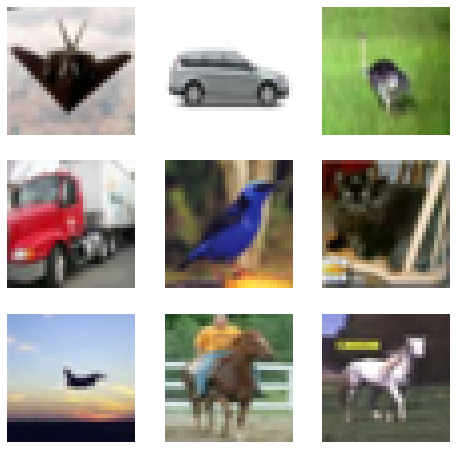

In [42]:
figure = plt.figure(figsize = (8,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  sample_idx = torch.randint(len(trainset), size= (1,)).item()
  img, label = trainset[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.axis("off")
  plt.imshow(np.transpose(img, (1,2,0)))

plt.show()

In [43]:
netE = tocuda(Encoder(latent_size, True))

In [44]:
netE

Encoder(
  (main1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01, inplace)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01, inplace)
  )
  (main2): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, 

In [45]:
netG = tocuda(Generator(latent_size))
netD = tocuda(Discriminator(latent_size, 0.2, 1))

In [46]:
#initializer 적용 
netE.apply(weights_init)
netG.apply(weights_init)
netD.apply(weights_init)


Discriminator(
  (infer_x): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Dropout2d(p=0.2)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace)
    (6): Dropout2d(p=0.2)
    (7): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01, inplace)
    (10): Dropout2d(p=0.2)
    (11): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.01, inplace)
    (14): Dropout2d(p=0.2)
    (15): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (16): BatchNorm2d(512, eps=1e-05, 

In [47]:
#optimizing

optimizerG =  optim.Adam([{'params' : netE.parameters()}, 
                          {'params' : netG.parameters()}], lr = lr, betas=(0.5,0.999)) 
# betas (Tuple[float, float], optional) – coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas = (0.5, 0.999)) 

criterion = nn.BCELoss()

In [48]:
# training 
g_loss_lst = []
d_loss_lst = []

for epoch in range(num_epochs):

  i=0
  for (data, target) in trainloader:

    real_label = tocuda(torch.ones(batch_size))
    fake_label= tocuda(torch.zeros(batch_size))

    noise1 = tocuda(torch.Tensor(data.size()).normal_(0, 0.1 * (num_epochs - epoch) / num_epochs))
    noise2 = tocuda(torch.Tensor(data.size()).normal_(0, 0.1 * (num_epochs - epoch) / num_epochs))

    if epoch == 0 and i == 0:
      netG.output_bias.data = get_log_odds(tocuda(data))

    if data.size()[0] != batch_size : # what does this do?
      continue
    
    d_real = tocuda(data) #real data 

    z_fake = tocuda(torch.randn(batch_size, latent_size, 1, 1)) #prior from normal distribution
    d_fake = netG(z_fake) # 

    z_real, _, _, _ =netE(d_real)
    z_real = z_real.view(batch_size, -1) # Returns a new tensor with the same data as the self tensor but of a different shape.

    mu, log_sigma = z_real[:, :latent_size], z_real[:, latent_size:] #QUESTION. don't understadny why assing mu and log_sigma like this
    sigma = torch.exp(log_sigma)
    epsilon = tocuda(torch.rand(batch_size, latent_size)) # *size, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=Fals

    output_z = mu + epsilon * sigma 

    output_real, _ = netD(d_real + noise1, output_z.view(batch_size, latent_size, 1, 1)) # discriminate real data to be ral 
    output_fake, _ = netD(d_fake + noise2, z_fake) # disriminate fake data  to be fake

    loss_d = criterion(output_real, real_label) + criterion(output_fake, fake_label)
    d_loss_lst.append(loss_d)
    loss_g = criterion(output_fake, real_label) + criterion(output_real, fake_label) # see if generator made fake sample looking real 
    g_loss_lst.append(loss_g)

    # train until generator loss < 3.5
    if loss_g.data.item() < 3.5:
      optimizerD.zero_grad() #Sets the gradients of all optimized torch.Tensor s to zero.
      loss_d.backward(retain_graph=True) 
      optimizerD.step()

    
    #train generator
    optimizerG.zero_grad()
    loss_g.backward()
    optimizerG.step()

    if i % 1 == 0 :
      print("Epoch : ", epoch, "iter : ", i, "D Loss : ", loss_d.item(), "G loss : ", loss_g.item(),
            "D(x) : ", output_real.mean().item(), "D(G(x)) : ", output_fake.mean().item())
      
    if i % 50 == 0 :
      vutils.save_image(d_fake.cpu().data[:16, ], './%s/fake.png' % (save_image_dir))
      vutils.save_image(d_real.cpu(), data[:16,], './%s/real.png' % (save_image_dir))

      i += 1 

    if epoch % 10 == 0 :
      torch.save(netG.state_dict(), './%s/netG_epoch_%d.pth' % (save_model_dir, epoch))
      torch.save(netE.state_dict(), './%s/netE_epoch_%d.pth' % (save_model_dir, epoch))
      torch.save(netD.state_dict(), './%s/netD_epoch_%d.pth' % (save_model_dir, epoch))

      vutils.save_image(d_fake.cpu().data[:16,], './%s/fake_%d/png' % (save_image_dir, epoch))


NotImplementedError: ignored